# Logistic Regression and Multinomial Extension

We would like to use an example to show how the best subset selection for logistic regression work in our program.

## Real Data Example

### Titanic Dataset

Consider the Titanic dataset obtained from the Kaggle competition: https://www.kaggle.com/c/titanic/data. 
The dataset consists of data about 889 passengers, and the goal of the competition is to predict the survival (yes/no) based on features including the class of service, the sex, the age etc. 

In [134]:
import numpy as np 
import pandas as pd

dt = pd.read_csv("./train.csv")
print(dt.head(5))

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


We only focus on some numeric or classification variables:

- predictor variables: $Pclass,\ Sex,\ Age,\ SibSp,\ Parch,\ Fare,\ Embarked$;
- response variable is $Survived$.

In [135]:
dt = dt.iloc[:, [1,2,4,5,6,7,9,11]] # variables interested
dt['Pclass'] = dt['Pclass'].astype(str)
print(dt.head(5))

   Survived Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0      3    male  22.0      1      0   7.2500        S
1         1      1  female  38.0      1      0  71.2833        C
2         1      3  female  26.0      0      0   7.9250        S
3         1      1  female  35.0      1      0  53.1000        S
4         0      3    male  35.0      0      0   8.0500        S


However, some rows contain missing value (NaN) and we need to drop them.

In [136]:
dt = dt.dropna()
print('sample size: ', dt.shape)

sample size:  (712, 8)


Then use dummy variables to replace classification variables:

In [137]:
dt1 = pd.get_dummies(dt)
print(dt1.head(5))

   Survived   Age  SibSp  Parch     Fare  Pclass_1  Pclass_2  Pclass_3  \
0         0  22.0      1      0   7.2500         0         0         1   
1         1  38.0      1      0  71.2833         1         0         0   
2         1  26.0      0      0   7.9250         0         0         1   
3         1  35.0      1      0  53.1000         1         0         0   
4         0  35.0      0      0   8.0500         0         0         1   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0           0         1           0           0           1  
1           1         0           1           0           0  
2           1         0           0           0           1  
3           1         0           0           0           1  
4           0         1           0           0           1  


Now we split `dt1` into training set and testing set:

In [138]:
from sklearn.model_selection import train_test_split
X = np.array(dt1.drop('Survived', axis = 1))
Y = np.array(dt1.Survived)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.33, random_state = 0)
print('train size: ', train_x.shape[0])
print('test size:', test_x.shape[0])

train size:  477
test size: 235


Here `train_x` contains:

- V0: dummy variable, 1st ticket class (1-yes, 0-no)
- V1: dummy variable, 2nd ticket class (1-yes, 0-no)
- V2: dummy variable, sex (1-male, 0-female)
- V3: Age
- V4: # of siblings / spouses aboard the Titanic
- V5: # of parents / children aboard the Titanic
- V6: Passenger fare
- V7: dummy variable, Cherbourg for embarkation (1-yes, 0-no)
- V8: dummy variable, Queenstown for embarkation (1-yes, 0-no)

And `train_y` indicates whether the passenger survived (1-yes, 0-no).

In [139]:
print('train_x:\n', train_x[0:5, :])
print('train_y:\n', train_y[0:5])

train_x:
 [[54.      1.      0.     59.4     1.      0.      0.      1.      0.
   1.      0.      0.    ]
 [30.      0.      0.      8.6625  0.      0.      1.      1.      0.
   0.      0.      1.    ]
 [47.      0.      0.     38.5     1.      0.      0.      0.      1.
   0.      0.      1.    ]
 [28.      2.      0.      7.925   0.      0.      1.      0.      1.
   0.      0.      1.    ]
 [29.      1.      0.     26.      0.      1.      0.      1.      0.
   0.      0.      1.    ]]
train_y:
 [1 0 0 0 1]


### Model Fitting

The `abessLogistic()` function in the `abess.linear` allows you to perform best subset selection in a highly efficient way. For example, in the Titanic sample, if you want to look for a best subset with no more than 5 variables on the logistic model, you can call:

In [140]:
from abess.linear import abessLogistic

s = 5   # max target sparsity
model = abessLogistic(support_size = range(0, s + 1))
model.fit(train_x, train_y)

abessLogistic(support_size=range(0, 6))

Now the `model.coef_` contains the coefficients of logistic model with no more than 5 variables. That is, those variables with a coefficient 0 is unused in the model: 

In [141]:
print(model.coef_)

[-0.05410776 -0.53642966  0.          0.          1.74091231  0.
 -1.26223831  2.7096497   0.          0.          0.          0.        ]


By default, the `abessLogistic` function set the `support_size = range(0, min(p,n/log(n)p)` and the best support size is determined by theExtended Bayesian Information Criteria (EBIC). You can change the tunging criterion by specifying the argument `ic_type`. The available tuning criterion now are `gic`, `aic`, `bic`, `ebic`. 

For a quicker solution, you can change the tuning strategy to a golden section path which trys to find the elbow point of the tuning criterion over the hyperparameter space. Here we give an example.

In [142]:
model_gs = abessLogistic(path_type = "gs", s_min = 0, s_max = s)
model_gs.fit(train_x, train_y)
print(model_gs.coef_)

[-0.05410776 -0.53642966  0.          0.          1.74091231  0.
 -1.26223831  2.7096497   0.          0.          0.          0.        ]


where `s_min` and `s_max` bound the support size and this model give the same answer as before.

### More on the Results

After fitting with `model.fit()`, we can further do more exploring work to interpret it. 
As we show above, `model.coef_` contains the sparse coefficients of variables and those non-zero values indicates "important" varibles chosen in the model.

In [143]:
print('Intercept: ', model.intercept_)
print('coefficients: \n', model.coef_)
print('Used variables\' index:', np.nonzero(model.coef_ != 0)[0])

Intercept:  [0.57429775]
coefficients: 
 [-0.05410776 -0.53642966  0.          0.          1.74091231  0.
 -1.26223831  2.7096497   0.          0.          0.          0.        ]
Used variables' index: [0 1 4 6 7]


The training loss and the score under information criterion:

In [144]:
print('Training Loss: ', model.train_loss_)
print('IC: ', model.ic_)

Training Loss:  [204.35270048]
IC:  [464.39204991]


Prediction is allowed for the estimated model. Just call `model.predict()` function like: 

In [145]:
fitted_y = model.predict(test_x)
print(fitted_y)

[0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Besides, you can also call for the survival probability of each observation by `model.predict_proba()`. Actually, those who with a probability greater than 0.5 is classified to "1" (survived).

In [146]:
fitted_p = model.predict_proba(test_x)
print(fitted_p)

[0.49256613 0.25942968 0.84928463 0.20204183 0.03801548 0.04022349
 0.72351443 0.23115622 0.23115622 0.66834673 0.96775535 0.64905946
 0.98461921 0.15238867 0.25004079 0.57640212 0.26995968 0.71264582
 0.37791835 0.1771314  0.25773297 0.75392142 0.87974411 0.40251569
 0.56441882 0.34057869 0.22005156 0.067159   0.57880531 0.33647767
 0.15655122 0.02682661 0.14553043 0.69663788 0.89078445 0.87925152
 0.91926004 0.59081387 0.42997279 0.45653474 0.38846964 0.09020182
 0.05742461 0.07773719 0.0994852  0.11006334 0.9819574  0.14219863
 0.1096089  0.96940171 0.71351188 0.69663788 0.63663757 0.25942968
 0.54978583 0.53309793 0.07032472 0.0706292  0.86889888 0.37901167
 0.43876674 0.03084541 0.14553043 0.19993615 0.29180956 0.11828599
 0.94586145 0.30610513 0.98763221 0.80911714 0.25942968 0.93051703
 0.9097025  0.51285362 0.04924417 0.53765354 0.48242039 0.26040948
 0.09474175 0.3384564  0.55107315 0.88025271 0.09058398 0.81733446
 0.86836852 0.09474175 0.04461544 0.28075505 0.78890012 0.1389

We can also generate an ROC curve and calculate tha AUC value. On this dataset, the AUC is 0.817, which is quite close to 1.

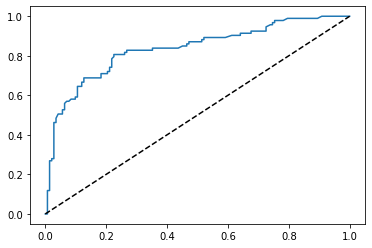

AUC:  0.8344691806754506


In [147]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(test_y, fitted_p)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

print('AUC: ', auc(fpr, tpr))


## Extension: Multi-class Classification

### Multinomial logistic regression

When the number of classes is more than 2, we call it multi-class classification task. Logistic regression can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one. The extended model is multinomial logistic regression.

To arrive at the multinomial logistic model, one can imagine, for $K$ possible classes, running $K−1$ independent logistic regression models, in which one class is chosen as a "pivot" and then the other $K−1$ classes are separately regressed against the pivot outcome. This would proceed as follows, if class K (the last outcome) is chosen as the pivot:

$$
\begin{aligned}
    \ln (\mathbb{P}(y=1)/\mathbb{P}(y=K)) = x^T\beta^{(1)},\\
    \dots\ \dots\\
    \ln (\mathbb{P}(y=K-1)/\mathbb{P}(y=K)) = x^T\beta^{(K-1)}.
\end{aligned}
$$

Then, the probability to choose the j-th class can be easily derived to be:

$$
    \mathbb{P}(y=j) = \frac{\exp(x^T\beta^{(j)})}{1+\sum_{k=1}^{K-1} \exp(x^T\beta^{(k)})},
$$

and subsequently, we would predict the $j^*$-th class if the $j^*=\arg\max_j \mathbb{P}(y=j)$. Notice that, for $K$ possible classes case, there are $p\times(K−1)$ unknown parameters: $\beta^{(1)},\dots,\beta^{(K−1)}$ to be estimated. Because the number of parameters increase as $K$, it is even more urge to constrain the model complexity. And the best subset selection for multinomial logistic regression aims to maximize the log-likelihood function and control the model complexity by restricting $B=(\beta^{(1)},\dots,\beta^{(K−1)})$ with $||B||_{0,2}\leq s$ where $||B||_{0,2}=\sum_{i=1}^p I(B_{i\cdot}=0)$, $B_{i\cdot}$ is the $i$-th row of coefficient matrix $B$ and $0\in R^{K-1}$ is an all zero vector. In other words, each row of $B$ would be either all zero or all non-zero.

### Simulated Data Example

We shall conduct Multinomial logistic regression on an artificial dataset for demonstration. The `make_multivariate_glm_data()` provides a simple way to generate suitable for this task. 

The assumption behind is the response vector following a multinomial distribution. The artifical dataset contain 100 observations and 20 predictors but only five predictors have influence on the three possible classes.

In [148]:
from abess.datasets import make_multivariate_glm_data
n = 100 # sample size
p = 20  # all predictors
k = 5   # real predictors
M = 3   # number of classes

np.random.seed(0)
dt =  make_multivariate_glm_data(n = n, p = p, k = k, family = "multinomial", M = M)
print(dt.coef_)
print('real variables\' index:\n', set(np.nonzero(dt.coef_)[0]))


[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 1.09734231  4.03598978  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 9.91227834 -3.47987303  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 8.93282229  8.93249765  0.        ]
 [-4.03426165 -2.70336848  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-5.53475149 -2.65928982  0.        ]
 [ 0.          0.          0.        ]]
real variables' index:
 {2, 5, 10, 11, 18}


To carry out best subset selection for multinomial logistic regression, we can call the `abessMultinomial()`. Here is an example.

In [149]:
from abess.linear import abessMultinomial
s = 5
model = abessMultinomial(support_size = range(0, s + 1))
model.fit(dt.x, dt.y)

abessMultinomial(support_size=range(0, 6))

Its use is quite similar to `abessLogistic`. We can get the coefficients to recognize "in-model" variables.

In [150]:
print('intercept:\n', model.intercept_)
print('coefficients:\n', model.coef_)

intercept:
 [21.42326269 20.715469   22.26781623]
coefficients:
 [[  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [ -3.48154954   5.76904948  -3.2394208 ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [ 23.04122134 -14.80633656  -7.28160058]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [ 13.76886614  11.64612255 -11.12983172]
 [ -3.73875599   0.62171172   3.80279815]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [ -9.19066393  -2.17011988  11.44410734]
 [  0.           0.           0.        ]]


So those variables used in model can be recognized and we ca find that they are the same as the data's "real" coefficients we generate.

In [151]:
print('used variables\' index:\n', set(np.nonzero(model.coef_)[0]))

used variables' index:
 {2, 5, 10, 11, 18}


## R tutorial

For R tutorial, please view [https://abess-team.github.io/abess/articles/v03-classification.html](https://abess-team.github.io/abess/articles/v03-classification.html).